<a href="https://colab.research.google.com/github/AhmedShaykhon/NU-Deep-Learning-Assignments/blob/master/Ahmed_Mostafa_Elsayed_Assignment_03_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning CIT690E Fall 2021
## Assignment 3
### Name: Ahmed Mostafa Elsayed Mohamed Shaykhon
### ID: 202000371

Q2) Python-Pytorch: Using MNIST dataset, compare in terms of the train and
test accuracies of two different ConvNet models (kernel width 5, 32 filters) at:
  • Stride of 1 and 2.
  • Calculate the total number of parameters for each case.
Q3) From the previous question, plot sample successful and failure cases, and
try to explain the effect of changing the Stride size on the results.

In [1]:
!pip install torch_summary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_data = MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_test_data = MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

val_data, test_data = random_split(val_test_data, [int(0.8 * len(val_test_data)), int(0.2 * len(val_test_data))])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

print("Training dataset size: ", len(train_data))
print("Validation dataset size: ", len(val_data))
print("Testing dataset size: ", len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training dataset size:  60000
Validation dataset size:  8000
Testing dataset size:  2000


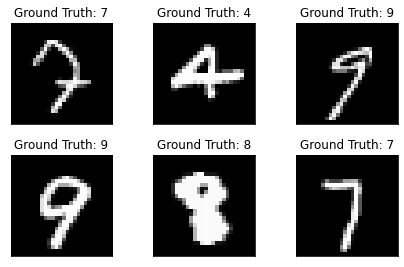

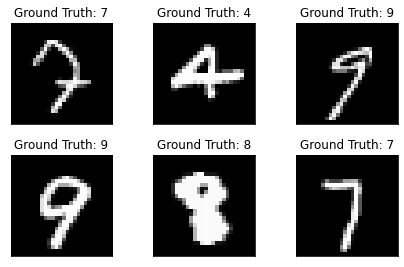

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
# Method 1 stride = 1
class CNN1(nn.Module):
    """Simple Convolutional Neural Network"""
    def __init__(self):
        super().__init__()

        # Create Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1) # assume pading = 0
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1) # assume pading = 0

        # Create Max Pooling Layer
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Create Fully Connected Layers
        self.fc1 = nn.Linear(512, 128) # image size from the second maxpol function is 4x4 then input size here shall be 4*4*32 = 512
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, input_image):
        # Convolution, ReLu and MaxPooling
        output = self.conv1(input_image) # number of paramters will be 5x5x32 and output image size will be 28 - 5 + 1 = 24
        output = F.relu(output) # apply relu activation function
        output = self.max_pool2d(output) # apply maxpol with kernal=2 and stride=2 will reduce image size from 24 to (24 - 2 + 2) / 2 = 12

        output = self.conv2(output) # number of paramters will be 5x5x12 and output image size will be 12 - 5 + 1 = 8
        output = F.relu(output) # apply relu activation function
        output = self.max_pool2d(output) # apply maxpol with kernal=2 and stride=2 will reduce image size from 8 to (8 - 2 + 2) / 2 = 4

        # Flatten
        output = output.view(-1, self.num_flat_features(output))
        
        # Fully Connected
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)

        return output

    def num_flat_features(self, image):
      size = image.size()[1:]
      num_features = 1
      for s in size:
          num_features *= s
          
      return num_features

In [7]:
input_size = 784
num_classes = 10

model = CNN1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model.cuda()
model

CNN1(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
summary(model, torch.zeros(1,1,28,28)) # total number of paramters is 93418

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 32, 8, 8]            25,632
├─MaxPool2d: 1-4                         [-1, 32, 4, 4]            --
├─Linear: 1-5                            [-1, 128]                 65,664
├─Linear: 1-6                            [-1, 10]                  1,290
Total params: 93,418
Trainable params: 93,418
Non-trainable params: 0
Total mult-adds (M): 2.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.36
Estimated Total Size (MB): 0.52


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 32, 8, 8]            25,632
├─MaxPool2d: 1-4                         [-1, 32, 4, 4]            --
├─Linear: 1-5                            [-1, 128]                 65,664
├─Linear: 1-6                            [-1, 10]                  1,290
Total params: 93,418
Trainable params: 93,418
Non-trainable params: 0
Total mult-adds (M): 2.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.36
Estimated Total Size (MB): 0.52

In [9]:
no_epochs = 20
train_loss = list()
val_loss = list()
best_val_loss = 1


Epoch: 1/20, Train Loss: 0.23784620, Val Loss: 0.06430196, Val Accuracy: 0.97950000
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.06430196

Epoch: 2/20, Train Loss: 0.06208301, Val Loss: 0.04701504, Val Accuracy: 0.98425000
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.04701504

Epoch: 3/20, Train Loss: 0.04437537, Val Loss: 0.03540099, Val Accuracy: 0.98825000
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03540099

Epoch: 4/20, Train Loss: 0.03354926, Val Loss: 0.03510486, Val Accuracy: 0.98787500
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.03510486

Epoch: 5/20, Train Loss: 0.02758848, Val Loss: 0.02772940, Val Accuracy: 0.99162500
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02772940

Epoch: 6/20, Train Loss: 0.02341163, Val Loss: 0.03997972, Val Accuracy: 0.98812500

Epoch: 7/20, Train Loss: 0.01931001, Val Loss: 0.03174630, Val Accuracy: 0.99012500

Epoc

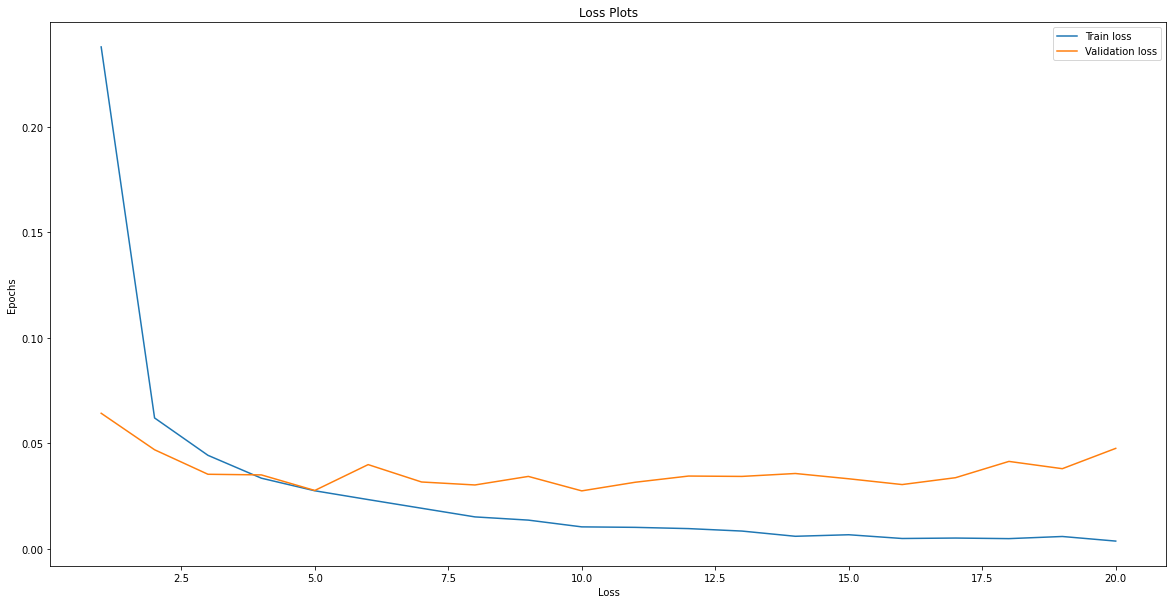

In [10]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = F.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(val_data)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [11]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

# store correct predictions
correct_results = list()
# store wrong predictions
wrong_results = list()
total = 0
for itr, (image, label) in enumerate(test_loader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = F.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            correct_results.append((image, torch.max(p.data, 0)[1]))

        else:
          wrong_results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(test_data)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.99200000


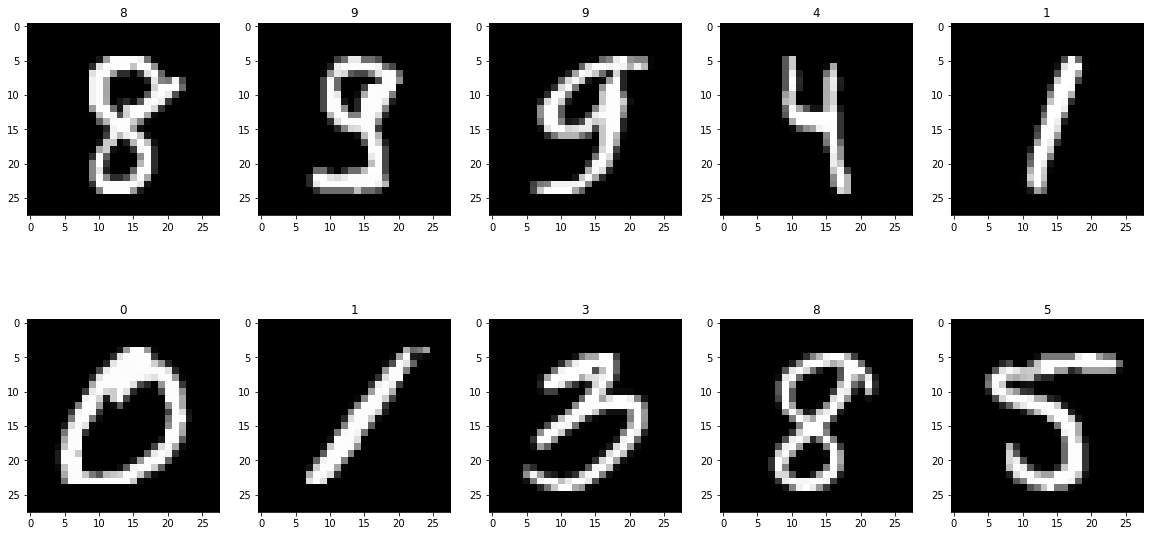

In [12]:
# visualize correct results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(correct_results))):
    img = transforms.ToPILImage(mode='L')(correct_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(correct_results[i][1].item())
    plt.imshow(img, cmap='gray', interpolation='none')
plt.show()

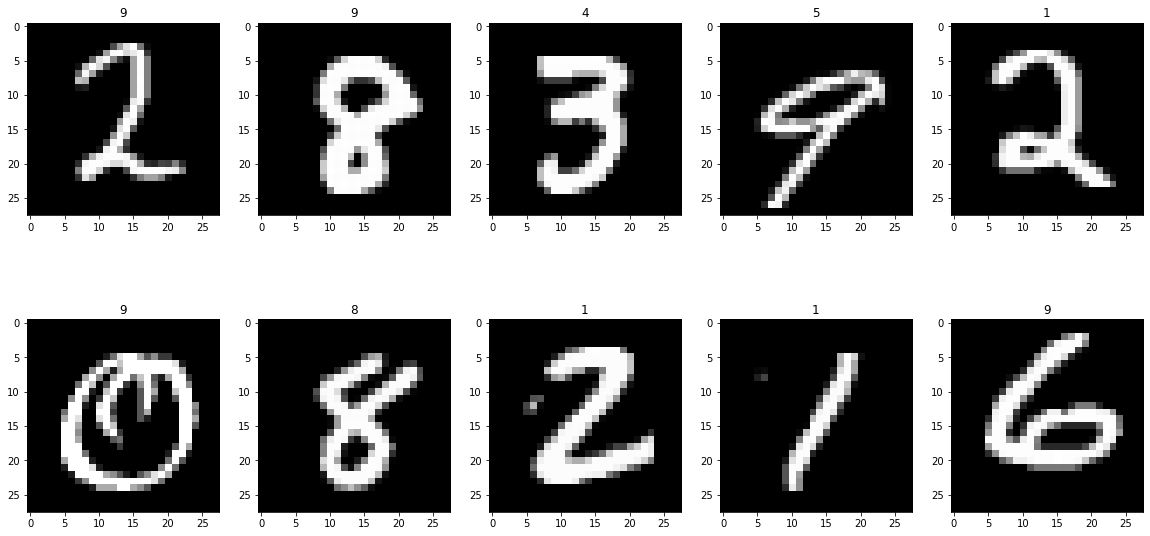

In [13]:
# visualize wrong results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(wrong_results))):
    img = transforms.ToPILImage(mode='L')(wrong_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(wrong_results[i][1].item())
    plt.imshow(img, cmap='gray', interpolation='none')
plt.show()

In [14]:
# Method 2 stride = 2
class CNN2(nn.Module):
    """Simple Convolutional Neural Network"""
    def __init__(self):
        super().__init__()

        # Create Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding= 1) # assume pading = 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding= 1) # assume pading = 1

        # Create Max Pooling Layer
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Create Fully Connected Layers
        self.fc1 = nn.Linear(32, 128) # image size from the maxpol function is 1x1 then input size here shall be 1*1*32 = 32
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, input_image):
        # Convolution, ReLu and MaxPooling
        output = self.conv1(input_image) # number of paramters will be 5x5x32 and output image size will be (28 - 5)/2 + 1 = 12.5 = 13
        output = F.relu(output) # apply relu activation function
        output = self.max_pool2d(output) # apply maxpol with kernal=2 and stride=2 will reduce image size from 13 to (13 - 2 + 2) / 2 = 6

        output = self.conv2(output) # number of paramters will be 5x5x6 and output image size will be 6 - 5 + 1 = 8
        output = F.relu(output) # apply relu activation function
        output = self.max_pool2d(output) # apply maxpol with kernal=2 and stride=2 will reduce image size from 6 to (6 - 2 + 2) / 2 = 3

        # Flatten
        output = output.view(-1, self.num_flat_features(output))
        
        # Fully Connected
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)

        return output

    def num_flat_features(self, image):
      size = image.size()[1:]
      num_features = 1
      for s in size:
          num_features *= s
          
      return num_features


In [15]:
input_size = 784
num_classes = 10

model = CNN2()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model.cuda()
model

CNN2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [16]:
summary(model, torch.zeros(1,1,28,28)) # total number of paramters is 31978

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 13, 13]          832
├─MaxPool2d: 1-2                         [-1, 32, 6, 6]            --
├─Conv2d: 1-3                            [-1, 32, 2, 2]            25,632
├─MaxPool2d: 1-4                         [-1, 32, 1, 1]            --
├─Linear: 1-5                            [-1, 128]                 4,224
├─Linear: 1-6                            [-1, 10]                  1,290
Total params: 31,978
Trainable params: 31,978
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.12
Estimated Total Size (MB): 0.17


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 13, 13]          832
├─MaxPool2d: 1-2                         [-1, 32, 6, 6]            --
├─Conv2d: 1-3                            [-1, 32, 2, 2]            25,632
├─MaxPool2d: 1-4                         [-1, 32, 1, 1]            --
├─Linear: 1-5                            [-1, 128]                 4,224
├─Linear: 1-6                            [-1, 10]                  1,290
Total params: 31,978
Trainable params: 31,978
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.12
Estimated Total Size (MB): 0.17

In [17]:
no_epochs = 20
train_loss = list()
val_loss = list()
best_val_loss = 1


Epoch: 1/20, Train Loss: 0.40724603, Val Loss: 0.10814979, Val Accuracy: 0.96775000
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.10814979

Epoch: 2/20, Train Loss: 0.10404238, Val Loss: 0.07576240, Val Accuracy: 0.97800000
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.07576240

Epoch: 3/20, Train Loss: 0.07317734, Val Loss: 0.06641405, Val Accuracy: 0.97912500
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.06641405

Epoch: 4/20, Train Loss: 0.05802601, Val Loss: 0.05145175, Val Accuracy: 0.98387500
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.05145175

Epoch: 5/20, Train Loss: 0.05078727, Val Loss: 0.05255774, Val Accuracy: 0.98400000

Epoch: 6/20, Train Loss: 0.04209165, Val Loss: 0.04729540, Val Accuracy: 0.98425000
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.04729540

Epoch: 7/20, Train Loss: 0.03799185, Val Loss: 0.04292710, Val Accuracy: 0.98550000
Savin

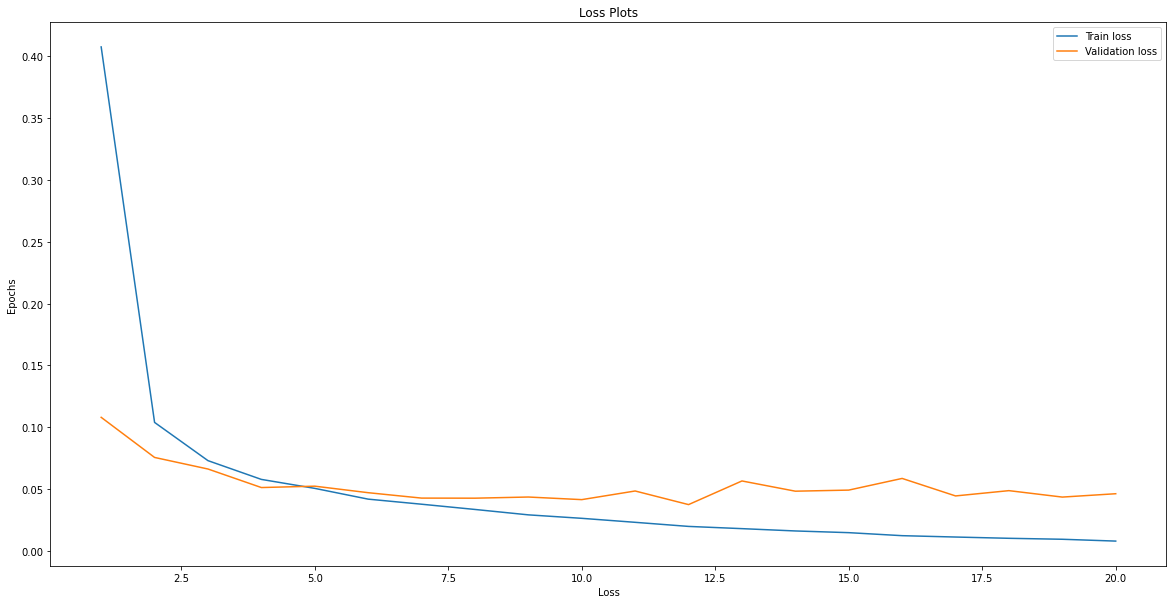

In [18]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = F.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(val_data)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [19]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

# store correct predictions
correct_results = list()
# store wrong predictions
wrong_results = list()
total = 0
for itr, (image, label) in enumerate(test_loader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = F.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            correct_results.append((image, torch.max(p.data, 0)[1]))

        else:
          wrong_results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(test_data)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.98650000


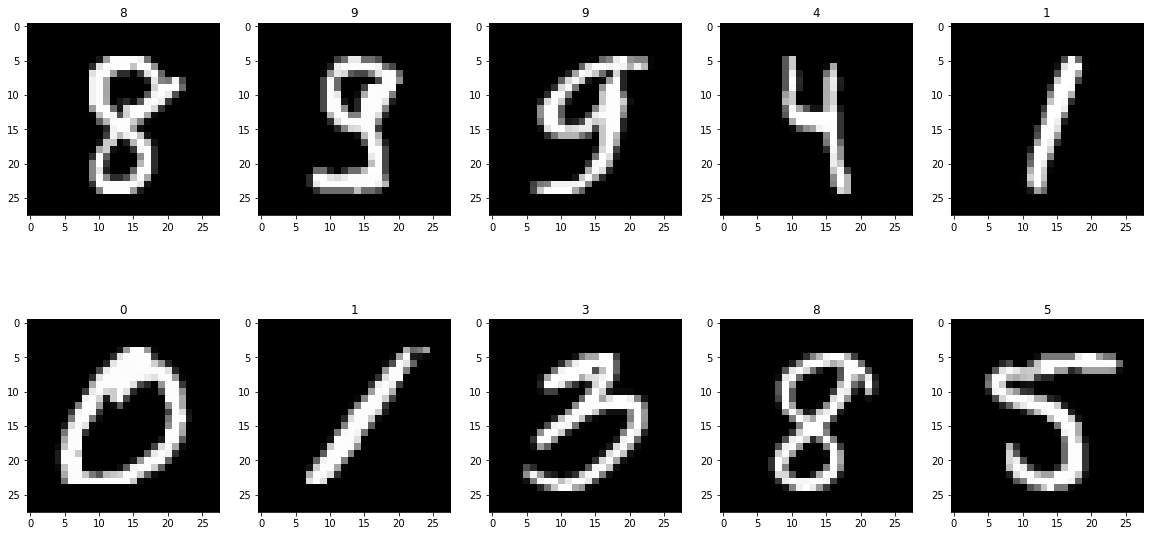

In [20]:
# visualize correct results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(correct_results))):
    img = transforms.ToPILImage(mode='L')(correct_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(correct_results[i][1].item())
    plt.imshow(img, cmap='gray', interpolation='none')
fig.show()

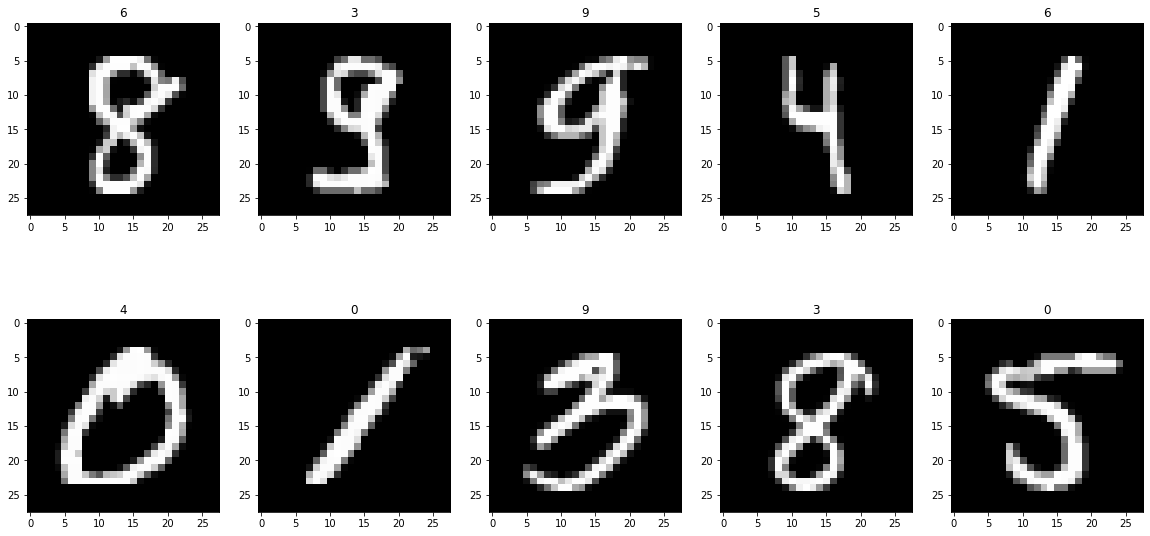

In [21]:
# visualize wrong results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(wrong_results))):
    img = transforms.ToPILImage(mode='L')(wrong_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(wrong_results[i][1].item())
    plt.imshow(img, cmap='gray', interpolation='none')
fig.show()